# Classificação de emoções com eletromiografia.

<p>No arquivo EMGsDataset.csv, esta disposto um conjunto de dados referente aos sinais de eletromiografia, captados 
nos musculos faciais: Corrugador do Superclio (Sensor 1); Zigomatico Maior (Sensor 2). O presente conjunto
 de dados foi obtido atraves de um grupo de sensores chamados Myoware Muscle Sensor, em conjunto com
 um microcontrolador NODEMCUESP32. As aquisicoes foram realizadas numa taxa de amostragem de 1Khz
 e a resolucao do ADC do microcontrolador e de 12 bits (0 4095). Os sensores foram posicionados em duas
 regioes diferentes da face de uma unica pessoa, em que o primeiro sensor se encontra na regiao do Corrugador do
 Superclio e o segundo foi posicionado no musculo Zigomatico Maior. As aquisicoes foram realizadas seguindo
 um roteiro de expressoes faciais forcadas com a seguinte ordem: neutro; sorriso; sobrancelhas levantadas;
 surpreso; rabugento. Este roteiro se repetiu 10 vezes e cada gesto foi posto durante 1 segundo.</p>

<p>A base de dados possui N = 50000 amostras, p = 2 caractersticas e C = 5 classes. Na
 primeira linha da matriz, existem os dados obtidos pelo sensor posicionado no Corrugador do Superclio. Na
 segunda linha da matriz, existem os dados obtidos pelo sensor posicionado no Zigomatico Maior. A terceira
 linha sao informacoes referentes da categoria para cada amostra, rotuladas da seguinte maneira:</p>

<ol>
<li>Neutro</li>
<li>Sorriso</li>
<li>Sobrancelhas levantadas</li>
<li>Surpreso</li>
<li>Rabugento</li>
</ol>

#### <ol><li>Organize os dados do arquivo em variaveis X e Y, de modo que elas sejam matrizes (numpy array)</li>


In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [2]:
file_path = 'EMGsDataset.csv'
df = pd.read_csv(file_path, header=None)

In [3]:
N = 50000 
p = 2 
C = 5 

In [4]:
sensor_corrugador = df.iloc[0, :].values
sensor_zigomatico = df.iloc[1, :].values
classes = df.iloc[p, :].values

Utilizaremos dois métodos diferentes para estimar os parâmetros do modelo:
<ul>
<li>Mínimos Quadrados Ordinários (MQO)</li>
<li>Gaussiano Bayesiano (GB)</li>
</ul>

Para cada um as variáveis X e Y terão dimensões diferentes.

$X \in \mathbb{R}^{Nxp} $ e $ Y \in \mathbb{R}^{NxC}$ para o MQO.
<br>
$X \in \mathbb{R}^{pxN}$ e $X \in \mathbb{R}^{CxN}$ para o GP.

In [5]:
X = np.column_stack((sensor_corrugador, sensor_zigomatico))
Y_one_hot = np.zeros((classes.size, C))
for i, class_label in enumerate(classes):
    Y_one_hot[i, int(class_label) - 1] = 1

In [6]:
print(X.shape)
print(Y_one_hot.shape)

(50000, 2)
(50000, 5)


#### 2 - Visualização inicial dos dados através do gráﬁco de espalhamento (destacando as categorias).

Para melhor legibilidade do gráfico, vamos estar separando as classes (emoções) por cores. Para isso será utilizado um loop para iterar por cada classe dando lhe uma cor diferente. Mas antes criemos um dicionário para relacionar as cores as emoções na legenda do gráfico.

In [7]:
class_names = {
    1: 'Neutro',
    2: 'Sorriso',
    3: 'Sobrancelhas Levantadas',
    4: 'Surpreso',
    5: 'Rabugento',
}

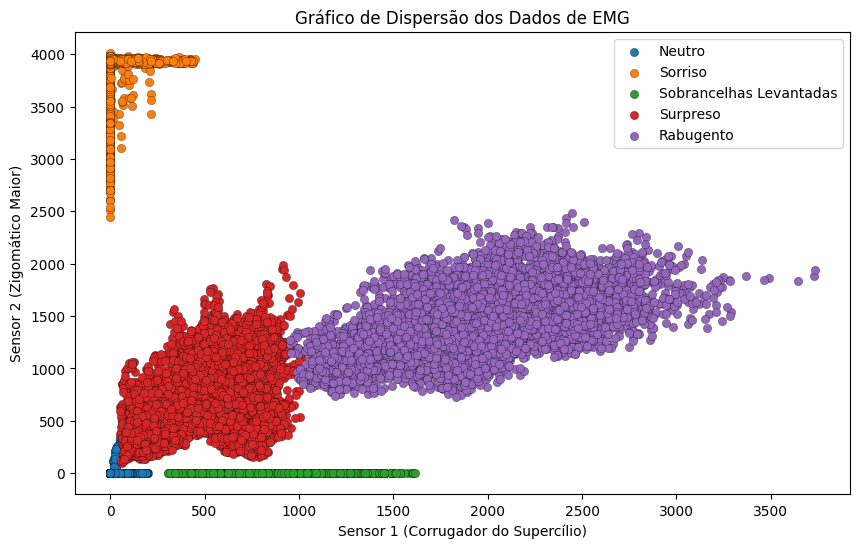

In [8]:
plt.figure(figsize=(10, 6)) 
for i in range(1, C + 1):
    plt.scatter(X[classes == i, 0], X[classes == i, 1], label=class_names[i], edgecolor='black', linewidth=0.2)

plt.xlabel('Sensor 1 (Corrugador do Supercílio)') 
plt.ylabel('Sensor 2 (Zigomático Maior)') 
plt.legend() 
plt.title(f'Gráfico de Dispersão dos Dados de EMG') 
plt.show() 

#### 3. Implementação de modelos classificadores

3.1. MQO Tradicional

In [9]:
def mqo(X, Y):
    """Função para o classificador MQO tradicional."""
    X_design = np.column_stack((np.ones(X.shape[0]), X))
    coefficients = np.linalg.pinv(X_design) @ Y 
    return coefficients    

3.2. Classificador Gaussiano Tradicional

In [10]:
def gaussian_classifier(X, Y, lambda_reg=0):
    """Função para o classificador gaussiano tradicional."""
    n_samples, n_features = X.shape
    n_classes = Y.shape[1]
    
    means = np.zeros((n_classes, n_features))
    covariances = np.zeros((n_classes, n_features, n_features))
    priors = np.zeros(n_classes)

    for i in range(n_classes):
        X_class = X[Y[:, i] == 1]
        means[i] = np.mean(X_class, axis=0)
        covariances[i] = np.cov(X_class, rowvar=False) + (lambda_reg * np.eye(n_features))  
        priors[i] = X_class.shape[0] / n_samples

    return means, covariances, priors

In [11]:
def predict_gaussian_classifier(X, means, covariances, priors):
    """Previsão do classificador gaussiano."""
    n_samples = X.shape[0]
    n_classes = means.shape[0]
    likelihoods = np.zeros((n_samples, n_classes))

    for i in range(n_classes):
        try:
            inv_cov = np.linalg.inv(covariances[i])
            diff = X - means[i]
            likelihood = (1 / np.sqrt((2 * np.pi) ** len(means[i]) * np.linalg.det(covariances[i]))) * \
                         np.exp(-0.5 * np.sum(diff @ inv_cov * diff, axis=1))
            likelihoods[:, i] = likelihood * priors[i]
        except np.linalg.LinAlgError:
            likelihoods[:, i] = priors[i]  

    return np.argmax(likelihoods, axis=1) + 1

3.3. Classificador de Bayes Ingênuo (Naive Bayes)

In [12]:
def naive_bayes_classifier(X, Y):
    """Função para o classificador Naive Bayes."""
    n_samples, n_features = X.shape
    n_classes = Y.shape[1]

    means = np.zeros((n_classes, n_features))
    variances = np.zeros((n_classes, n_features))
    priors = np.zeros(n_classes)

    for i in range(n_classes):
        X_class = X[Y[:, i] == 1]
        means[i] = np.mean(X_class, axis=0)
        variances[i] = np.var(X_class, axis=0) + 1e-6  
        priors[i] = X_class.shape[0] / n_samples

    return means, variances, priors

In [13]:
def predict_naive_bayes_classifier(X, means, variances, priors):
    """Previsão do classificador Naive Bayes."""
    n_samples = X.shape[0]
    n_classes = means.shape[0]
    likelihoods = np.zeros((n_samples, n_classes))

    for i in range(n_classes):
        likelihood = (1 / np.sqrt(2 * np.pi * variances[i])) * np.exp(-0.5 * ((X - means[i]) ** 2) / variances[i])
        likelihoods[:, i] = np.prod(likelihood, axis=1) * priors[i]

    return np.argmax(likelihoods, axis=1) + 1

#### 4. Para o classificador gaussiano regularizado, há a dependência da definição de seu hiperparâmetro λ. Assim, sua equipe deve testar o presente modelo para os seguintes valores de lambda:

In [14]:
lambda_values = (0.25, 0.5, 0.75)

#### 5. Para validação dos modelos de classificação, utilizaremos as simulações por Monte Carlo. Essa etapa, terá um total de rodadas igual a R = 500. Em cada rodada, realizaremos o particionamento em 80% dos dados para treinamento e 20% para teste. A medida de desempenho de cada um dos 5 modelos diferentes deve ser a acurácia (taxa de acerto), e cada medida obtida deve ser armazenada em uma lista.

In [15]:
R = 500
accuracies = {lambda_val: [] for lambda_val in lambda_values}
accuracies['MQO'] = []
accuracies['Gaussian Tradicional'] = []
accuracies['Gaussian Cov. Treino'] = []
accuracies['Gaussian Agregada'] = []
accuracies['Naive Bayes'] = []

indices = np.arange(X.shape[0])
train_size = int(0.8 * len(indices))

In [16]:
for _ in range(R):

    np.random.shuffle(indices)
    
    train_indices = indices[:train_size]
    test_indices = indices[train_size:]

    X_train, X_test = X[train_indices], X[test_indices]
    Y_train, Y_test = Y_one_hot[train_indices], Y_one_hot[test_indices]
    class_labels_test = classes[test_indices]

    mqo_coefficients = mqo(X_train, Y_train)
    predictions_mqo = np.argmax(X_test @ mqo_coefficients[1:, :], axis=1) + 1  # Ignorar intercepto
    accuracy_mqo = np.mean(predictions_mqo == class_labels_test)

    means_gaussian, covariances_gaussian, priors_gaussian = gaussian_classifier(X_train, Y_train)
    predictions_gaussian = predict_gaussian_classifier(X_test, means_gaussian, covariances_gaussian, priors_gaussian)
    accuracy_gaussian = np.mean(predictions_gaussian == class_labels_test)

    means_gaussian_all, covariances_gaussian_all, priors_gaussian_all = gaussian_classifier(X_train, Y_train)
    covariances_all = np.mean(covariances_gaussian_all, axis=0)  # Covariância média
    predictions_gaussian_all = predict_gaussian_classifier(X_test, means_gaussian_all, np.repeat(covariances_all[np.newaxis, :, :], C, axis=0), priors_gaussian_all)
    accuracy_gaussian_all = np.mean(predictions_gaussian_all == class_labels_test)

    covariances_aggregated = np.cov(X_train, rowvar=False)  # Calcular covariância agregada
    means_gaussian_aggregated, _, priors_gaussian_aggregated = gaussian_classifier(X_train, Y_train)

    predictions_gaussian_aggregated = predict_gaussian_classifier(X_test, means_gaussian_aggregated, np.repeat(covariances_aggregated[np.newaxis, :, :], C, axis=0), priors_gaussian_aggregated)
    accuracy_gaussian_aggregated = np.mean(predictions_gaussian_aggregated == class_labels_test)

    means_nb, variances_nb, priors_nb = naive_bayes_classifier(X_train, Y_train)
    predictions_nb = predict_naive_bayes_classifier(X_test, means_nb, variances_nb, priors_nb)
    accuracy_nb = np.mean(predictions_nb == class_labels_test)

    for lambda_val in lambda_values:
        means_regularized, covariances_regularized, priors_regularized = gaussian_classifier(X_train, Y_train, lambda_reg=lambda_val)
        predictions_regularized = predict_gaussian_classifier(X_test, means_regularized, covariances_regularized, priors_regularized)
        accuracy_regularized = np.mean(predictions_regularized == class_labels_test)
        accuracies[lambda_val].append(accuracy_regularized)

    accuracies['MQO'].append(accuracy_mqo)
    accuracies['Gaussian Tradicional'].append(accuracy_gaussian)
    accuracies['Gaussian Cov. Treino'].append(accuracy_gaussian_all)
    accuracies['Gaussian Agregada'].append(accuracy_gaussian_aggregated)
    accuracies['Naive Bayes'].append(accuracy_nb)

#### Ao ﬁnal das R rodadas calcularemos para cada modelo utilizado, média aritmética, desvio-padrão, valor maior, valor menor das acurácias obtidas para cada modelo. Coloque os resultados obtidos em uma tabela (exemplo fornecido) e discuta os resultados obtidos. Obs: O resultado não precisa ser limitado a tabela, como pode ser expresso via gráﬁcos!

In [17]:
results = {}
for key in accuracies.keys():
    results[key] = {
        'média': np.mean(accuracies[key]),
        'desvio padrão': np.std(accuracies[key]),
        'valor máximo': np.max(accuracies[key]),
        'valor mínimo': np.min(accuracies[key])
    }

In [18]:
name_mapping = {
    'MQO': 'MQO tradicional',
    'Gaussian Tradicional': 'Gaussiano Tradicional',
    'Gaussian Cov. Treino': 'Gaussiano (Cov. de todo cj. treino)',
    'Gaussian Agregada': 'Gaussiano (Cov. Agregada)',
    'Naive Bayes': 'Bayes Ingênuo',
    0.25: 'Gaussiano Regularizado (λ =0,25)',
    0.5: 'Gaussiano Regularizado (λ =0,5)',
    0.75: 'Gaussiano Regularizado (λ =0,75)',
}

In [19]:
results_df = pd.DataFrame(results).T
results_df.index = [name_mapping.get(key, key) for key in results_df.index]

print(results_df)


                                        média  desvio padrão  valor máximo  \
Gaussiano Regularizado (λ =0,25)     0.995765       0.000659        0.9976   
Gaussiano Regularizado (λ =0,5)      0.996055       0.000574        0.9978   
Gaussiano Regularizado (λ =0,75)     0.996123       0.000562        0.9978   
MQO tradicional                      0.545785       0.004417        0.5584   
Gaussiano Tradicional                0.200138       0.003716        0.2129   
Gaussiano (Cov. de todo cj. treino)  0.962520       0.001874        0.9689   
Gaussiano (Cov. Agregada)            0.948490       0.002645        0.9566   
Bayes Ingênuo                        0.965482       0.001711        0.9701   

                                     valor mínimo  
Gaussiano Regularizado (λ =0,25)           0.9936  
Gaussiano Regularizado (λ =0,5)            0.9939  
Gaussiano Regularizado (λ =0,75)           0.9942  
MQO tradicional                            0.5330  
Gaussiano Tradicional                

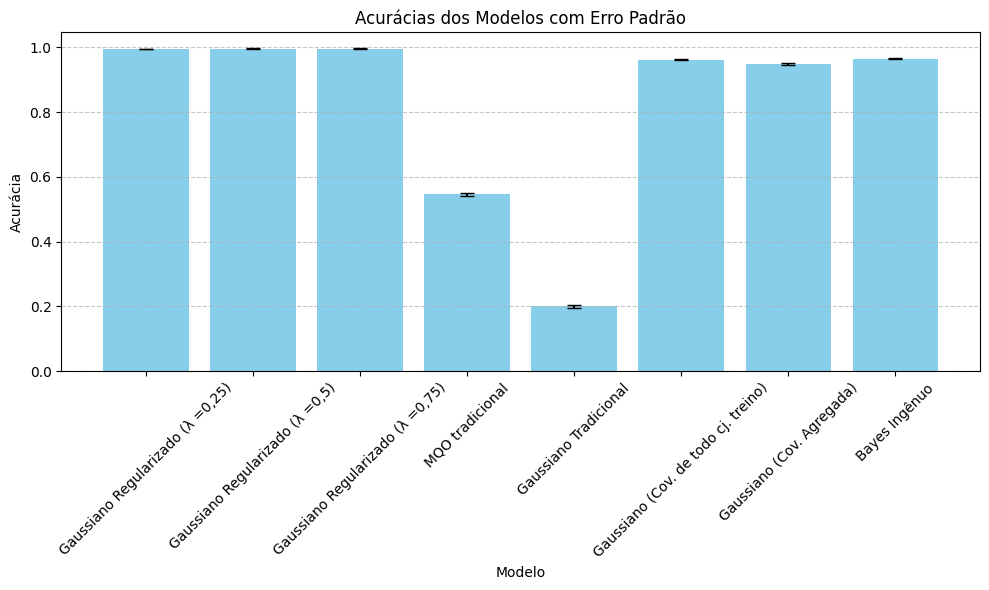

In [20]:
plt.figure(figsize=(10, 6))

model_names = results_df.index

plt.bar(model_names, results_df['média'], yerr=results_df['desvio padrão'], capsize=5, color='skyblue')

plt.title('Acurácias dos Modelos com Erro Padrão')
plt.xlabel('Modelo')
plt.ylabel('Acurácia')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()